<a href="https://colab.research.google.com/github/James-Wirth/pair-trading/blob/main/pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'META', 'TSLA', 'CRM', 'AMD', 'INTC', 'EA', 'ZG', 'MTCH', 'YELP']
start_date = "2022-02-10"
end_date = "2024-02-10"
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

[*********************100%%**********************]  14 of 14 completed


Normalise the closing prices to the range $[0,1]$

In [3]:
close = pd.DataFrame()
for ticker in tickers:
    close[ticker] = data[ticker]['Close']
norm_close = (close - close.min())/(close.max()-close.min())
norm_close

,AAPL,MSFT,GOOG,AMZN,NVDA,META,TSLA,CRM,AMD,INTC,EA,ZG,MTCH,YELP
Date,,,,,,,,,,,,,,
2022-02-10,0.644411,0.427193,0.772425,0.833245,0.239664,0.360443,0.706631,0.546188,0.561380,0.876051,0.777744,0.550449,0.955106,0.389741
2022-02-11,0.596798,0.391614,0.709741,0.771602,0.208879,0.338375,0.652378,0.486498,0.460166,0.831079,0.751206,0.710512,0.936882,0.451995
2022-02-14,0.600082,0.391420,0.726139,0.791828,0.214100,0.333584,0.671570,0.477334,0.468928,0.829251,0.730096,0.801109,0.948216,0.451556
2022-02-15,0.653578,0.417935,0.741913,0.806332,0.250681,0.342131,0.728405,0.525293,0.526811,0.860695,0.763269,1.000000,1.000000,0.489698
2022-02-16,0.650294,0.413233,0.756798,0.823497,0.250944,0.330579,0.729574,0.509958,0.496423,0.853016,0.726779,0.958532,0.987665,0.473915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,0.857299,0.927775,0.861107,0.955306,0.954011,0.959646,0.266553,0.976539,0.950961,0.653382,0.776538,0.719493,0.077898,0.798334
2024-02-06,0.879464,0.927000,0.867835,0.942783,0.935803,0.947498,0.281313,0.962610,0.899912,0.652285,0.786188,0.748019,0.084343,0.816309
2024-02-07,0.880969,0.968492,0.885634,0.957681,0.966604,0.986013,0.290373,0.980999,0.924512,0.653748,0.831122,0.753566,0.070786,0.805787


Run the Phillips Ouliaris cointegration test pairwise and determine which pairs are cointegrated to $p < 0.05$.

In [4]:
%pip install arch
from arch.unitroot.cointegration import phillips_ouliaris
from itertools import combinations

pairs = list(combinations(tickers, 2))

for i, pair in enumerate(pairs):
    X = norm_close[pair[0]]
    y = norm_close[pair[1]]
    coint = phillips_ouliaris(X, y, trend="c", test_type="Zt")
    if(coint.pvalue<0.05):
        print(pair)
        print(coint.pvalue)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 14.7 MB/s eta 0:00:00
('MSFT', 'META')
0.004889829843156466
('MSFT', 'CRM')
0.01764887604131975
('META', 'CRM')
0.04902798619077374
('CRM', 'AMD')
0.0035118400660488856


MSFT and META have $p \sim 0.0049$. Calculate the rolling spread and then normalise the spread by the standard deviation (i.e. calculate the $z$-score).

In [5]:
import statsmodels.api as sm

X = norm_close['MSFT']
y = norm_close['META']

lag = 10
beta = [np.nan] * lag
for i in range(lag, len(X)):
    X_trunc = X[(i - lag):i]
    y_trunc = y[(i - lag):i]
    beta.append(sm.OLS(y_trunc, X_trunc).fit().params[0])

spread =  y - beta*X
rolling_spread = spread.rolling(window=lag).mean()
zscore = (rolling_spread - rolling_spread.mean())/rolling_spread.std()

- Trades opened when $|z|$ crosses from $|z|$ < `trade_limit` to $|z|$ > `trade_limit`.
- Trades closed when $|z|$ reaches zero again (i.e. when the spread reverts to its mean of zero), giving profit.
- Trades also closed when $|z|$ crosses from $|z|$ < `stop_limit` to $|z|$ > `stop_limit`, i.e. if the stop loss threshold is exceeded due to a shock in the stock price.

In [6]:
trade_limit = 1.2
stop_limit = 2.5

def trade(X, y, zscore):

    open = False
    entry_z = 0
    entry_indexes = []
    exit_indexes = []
    profit = 0

    for i in range(1,zscore.shape[0]):
        if(open):
            if((zscore[i] < -1*stop_limit and zscore[i-1] > -1*stop_limit)
            or (zscore[i] > stop_limit and zscore[i-1] < stop_limit)):
                  open = False
                  profit -= abs(zscore[i] - entry_z)
                  #print("CLOSED (stop loss), profit = " + str(-abs(zscore[i] - entry_z)) + "\n")
                  exit_indexes.append(i)

            if((zscore[i] > 0 and zscore[i-1] < 0)
            or (zscore[i] < 0 and zscore[i-1] > 0)):
                  open = False
                  profit += abs(zscore[i] - entry_z)
                  #print("CLOSED, profit = " + str(abs(zscore[i] - entry_z)) + "\n")
                  exit_indexes.append(i)
        else:
            if((zscore[i] < -1*trade_limit and zscore[i-1] > -1*trade_limit)
            or (zscore[i] > trade_limit and zscore[i-1] < trade_limit)):
                  entry_z = zscore[i]
                  open = True
                  #print("OPEN, zscore = " + str(entry_z))
                  entry_indexes.append(i)

    return entry_indexes, exit_indexes, profit

Plot the $z$ score as well as the entry and exit points defined by the trading strategy.

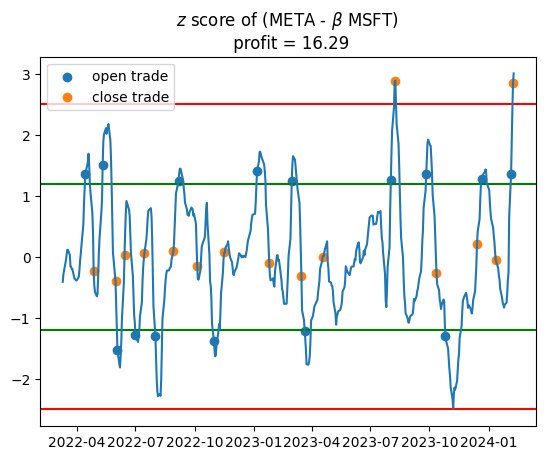

In [7]:
import matplotlib.dates as mdates

def plot_signals(entry_indexes, exit_indexes, zscore, profit):

    dates = zscore.index[:]
    entry_dates = zscore.index[entry_indexes]
    exit_dates = zscore.index[exit_indexes]

    all_zscores = []
    entry_zscores = []
    exit_zscores = []
    for i in dates:
        all_zscores.append(zscore[i])
    for i in entry:
        entry_zscores.append(zscore[i])
    for i in exit:
        exit_zscores.append(zscore[i])

    for i in [-1,1]:
        plt.axhline(y=i*trade_limit, color='g', linestyle='-')
    for i in [-1,1]:
        plt.axhline(y=i*stop_limit, color='r', linestyle='-')

    plt.scatter(entry_dates.to_pydatetime(), entry_zscores, label = "open trade")
    plt.scatter(exit_dates.to_pydatetime(), exit_zscores, label = "close trade")
    plt.plot(dates.to_pydatetime(), all_zscores)
    plt.title(f"$z$ score of (META - $\\beta$ MSFT) \n profit = {round(profit, 2)}")
    plt.legend()
    plt.show()

entry, exit, profit = trade(X,y,zscore)
plot_signals(entry, exit, zscore, profit)